## model using
### begin from this(read data which had been saved)

In [58]:
import numpy as np
import pandas as pd
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt


from tqdm import tqdm
from io import StringIO
from contextlib import redirect_stdout
import logging
logging.getLogger('implied_vol_solver').setLevel(logging.WARNING)  # 只显示警告和错误
from tqdm import tqdm

from implied_vol_solver import CDSImpliedVolatilitySolver, CDSQuoteType
from options_optimizer import EquityOption, OptionType, EQ_OPTION_PRICING_FACTOR

### Specify As of Date

In [33]:
as_of_date = '2024-12-31'

---

### CGM stuff - Implied vol and generateing stock table

In [59]:
cgm_df = pd.read_csv('res/input_data.csv',index_col='date')
# cgm_df = cgm_df.loc[[as_of_date]]

In [60]:
# implied vol calculation
# S = 100.0        # stock price
# D = 150.0        # debt per share
t = 5.0          # CDS tenor
r = 0.05         # risk free rate
R = 0.4          # recovery rate
L = 0.5          # loss given default
lamb = 0.3       # barrier deviation
notional = -1_000_000  # negative for sell CDS protection/buy stock      
cds_coupon = 0.01
# in practice, the below are chosen based on liquidity of hedging options, expected range of stock movement, among other things
min_stk_px = 7.
max_stk_px = 15.


In [61]:

# create new columns
cgm_df['implied_vol'] = np.nan 
cgm_df['par_spread_error'] = np.nan
solver = CDSImpliedVolatilitySolver(t, r, L, lamb, CDSQuoteType.UPFRONT)

with redirect_stdout(StringIO()):
    for i, row in tqdm(cgm_df.iterrows()):
        # imply vol by CDS upfront
        market_cds_upfront = row['upfront']
        cds_coupon = row['runningcoupon']
        R = row['cdsassumedrecovery']
        D = row['financial_debt_ratio']
        S = row['stock_price']
        implied_vol, error = solver.solve_implied_volatility(S, D, market_cds_upfront, cds_coupon, R, method='brent')
        cgm_df.at[i, 'implied_vol'] = implied_vol
        cgm_df.at[i, 'par_spread_error'] = error

1003it [00:04, 225.98it/s]


In [62]:
from generate_daily_hedge_maps import generate_daily_stock_share_maps

# 使用已有的df(output_data.csv)
stock_share_maps = generate_daily_stock_share_maps(
    cgm_df, 
    t=t, 
    r=r, 
    L=L, 
    lamb=lamb, 
    notional = notional, # negative for sell CDS protection/buy stock
    min_price = min_stk_px,
    max_price = max_stk_px,
    output_dir='res/hedge_maps'
)


Generating hedge maps: 100%|██████████| 1003/1003 [00:37<00:00, 27.08it/s]


In [38]:
sample_map = list(stock_share_maps.values())[-1]

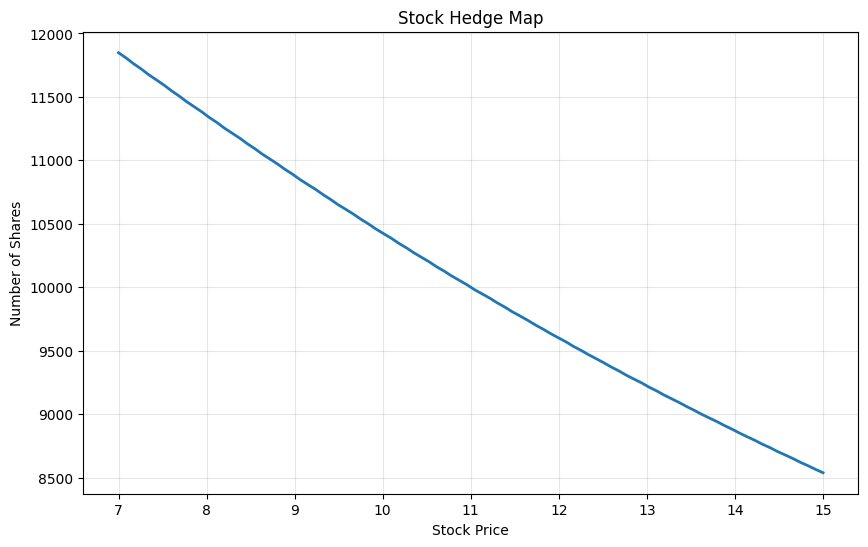

In [39]:
# Plot the hedge map
plt.figure(figsize=(10, 6))
prices = list(sample_map.keys())
shares = list(sample_map.values())
plt.plot(prices, shares, linewidth=2)
plt.xlabel('Stock Price')
plt.ylabel('Number of Shares')
plt.title('Stock Hedge Map')
plt.grid(True, alpha=0.3)
plt.show()


In [11]:
min_stk_shares = sample_map[min_stk_px]
# min_stk_shares 

---

### Choosing the hedging OTM put option

In [12]:
# Read the options data from CSV file
options_df = pd.read_csv('opt_stock_data/opt_data_XRX.csv')

# massage data
options_df['date'] = pd.to_datetime(options_df['date'])
options_df = options_df.sort_values('date')
options_df['expiration_date'] = pd.to_datetime(options_df['expiration_date'])
options_df['expiry_in_years'] = (options_df['expiration_date'] - options_df['date']).dt.days / 365.25
options_df['stock_price'] = options_df['und_day_close']
options_df['option_price'] = options_df['day_close']
options_df['implied_vol'] = options_df['iv']


In [13]:
options_df = options_df.loc[(options_df.date == as_of_date)&(options_df.option_type.str.upper()=='P')]
options_df

,date,und_ticker,ticker,option_type,strike_price,expiration_date,day_open,day_high,day_low,day_close,...,iv,delta,gamma,vega,theta,open_interest,expiry_in_years,stock_price,option_price,implied_vol
28405,2024-12-31,XRX,O:XRX250221P00009000,P,9,2025-02-21,0.85,0.85,0.85,0.85,...,0.393443,-0.642940,0.297992,0.011870,-0.004491,20.0,0.142368,8.43,0.85,0.393443
28403,2024-12-31,XRX,O:XRX250221P00007000,P,7,2025-02-21,0.20,0.20,0.20,0.20,...,0.599036,-0.174848,0.135165,0.008198,-0.004722,22.0,0.142368,8.43,0.20,0.599036
28404,2024-12-31,XRX,O:XRX250221P00008000,P,8,2025-02-21,0.45,0.50,0.45,0.50,...,0.562139,-0.362104,0.209580,0.011928,-0.006447,3700.0,0.142368,8.43,0.50,0.562139
28396,2024-12-31,XRX,O:XRX250117P00017000,P,17,2025-01-17,8.30,8.30,8.30,8.30,...,0.000005,-1.000000,0.000000,0.000000,0.000000,1415.0,0.046543,8.43,8.30,0.000005
28394,2024-12-31,XRX,O:XRX250117P00011000,P,11,2025-01-17,2.25,2.25,2.25,2.25,...,0.000005,-1.000000,0.000000,0.000000,0.000000,269.0,0.046543,8.43,2.25,0.000005
28393,2024-12-31,XRX,O:XRX250117P00010000,P,10,2025-01-17,1.23,1.23,1.23,1.23,...,0.000005,-1.000000,0.000000,0.000000,0.000000,6690.0,0.046543,8.43,1.23,0.000005
28392,2024-12-31,XRX,O:XRX250117P00008000,P,8,2025-01-17,0.13,0.17,0.13,0.17,...,0.485244,-0.290370,0.387977,0.006231,-0.008893,14552.0,0.046543,8.43,0.17,0.485244
28391,2024-12-31,XRX,O:XRX250117P00007000,P,7,2025-01-17,0.01,0.01,0.01,0.01,...,0.468106,-0.029343,0.078441,0.001215,-0.001673,23052.0,0.046543,8.43,0.01,0.468106
28395,2024-12-31,XRX,O:XRX250117P00012000,P,12,2025-01-17,3.28,3.28,3.28,3.28,...,0.000005,-1.000000,0.000000,0.000000,0.000000,126.0,0.046543,8.43,3.28,0.000005


### Check if the BS delta calc is working - bs_delta should be close to delta: see abs_delta_diff_check

In [14]:
def calculate_bs_delta_for_row(row):
    """Calculate Black-Scholes delta for a single row of options data."""
    assert row['option_type'].upper() in {'C', 'P'}, "Invalid option type"
    option_type = OptionType.CALL if row['option_type'].upper() == 'C' else OptionType.PUT
    
    # Create EquityOption instance
    option = EquityOption(
        strike=row['strike_price'],
        expiry_in_years=row['expiry_in_years'],
        option_type=option_type,
        implied_vol=row['implied_vol'],
        option_price=row['option_price']
    )
    
    # Calculate Black-Scholes delta using the stock price from the row
    bs_delta = option.calculate_bs_delta(stock_price=row['stock_price'], interest_rate=0.0)
    return bs_delta

# Add bs_delta column to the options dataframe
options_df['bs_delta'] = options_df.apply(calculate_bs_delta_for_row, axis=1)
options_df['abs_delta_diff_check'] = abs(options_df['bs_delta'] - options_df['delta'])

In [15]:
options_df.sort_values('strike_price')

,date,und_ticker,ticker,option_type,strike_price,expiration_date,day_open,day_high,day_low,day_close,...,gamma,vega,theta,open_interest,expiry_in_years,stock_price,option_price,implied_vol,bs_delta,abs_delta_diff_check
28403,2024-12-31,XRX,O:XRX250221P00007000,P,7,2025-02-21,0.20,0.20,0.20,0.20,...,0.135165,0.008198,-0.004722,22.0,0.142368,8.43,0.20,0.599036,-0.174785,0.000063
28391,2024-12-31,XRX,O:XRX250117P00007000,P,7,2025-01-17,0.01,0.01,0.01,0.01,...,0.078441,0.001215,-0.001673,23052.0,0.046543,8.43,0.01,0.468106,-0.029302,0.000041
28404,2024-12-31,XRX,O:XRX250221P00008000,P,8,2025-02-21,0.45,0.50,0.45,0.50,...,0.209580,0.011928,-0.006447,3700.0,0.142368,8.43,0.50,0.562139,-0.362086,0.000018
28392,2024-12-31,XRX,O:XRX250117P00008000,P,8,2025-01-17,0.13,0.17,0.13,0.17,...,0.387977,0.006231,-0.008893,14552.0,0.046543,8.43,0.17,0.485244,-0.290317,0.000053
28405,2024-12-31,XRX,O:XRX250221P00009000,P,9,2025-02-21,0.85,0.85,0.85,0.85,...,0.297992,0.011870,-0.004491,20.0,0.142368,8.43,0.85,0.393443,-0.643006,0.000066
28393,2024-12-31,XRX,O:XRX250117P00010000,P,10,2025-01-17,1.23,1.23,1.23,1.23,...,0.000000,0.000000,0.000000,6690.0,0.046543,8.43,1.23,0.000005,-1.000000,0.000000
28394,2024-12-31,XRX,O:XRX250117P00011000,P,11,2025-01-17,2.25,2.25,2.25,2.25,...,0.000000,0.000000,0.000000,269.0,0.046543,8.43,2.25,0.000005,-1.000000,0.000000
28395,2024-12-31,XRX,O:XRX250117P00012000,P,12,2025-01-17,3.28,3.28,3.28,3.28,...,0.000000,0.000000,0.000000,126.0,0.046543,8.43,3.28,0.000005,-1.000000,0.000000
28396,2024-12-31,XRX,O:XRX250117P00017000,P,17,2025-01-17,8.30,8.30,8.30,8.30,...,0.000000,0.000000,0.000000,1415.0,0.046543,8.43,8.30,0.000005,-1.000000,0.000000


### Manually choose the most OTM and longest tenor option available, for illustrations

In [16]:
idx = 1
chosen_option = options_df.iloc[idx]
option_type = OptionType.CALL if chosen_option['option_type'].upper() == 'C' else OptionType.PUT
# Create EquityOption instance
option = EquityOption(
    strike=chosen_option['strike_price'],
    expiry_in_years=chosen_option['expiry_in_years'],
    option_type=option_type,
    implied_vol=chosen_option['implied_vol'],
    option_price=chosen_option['option_price']
)
num_contracts = abs(int(min_stk_shares / (option.calculate_bs_delta() * EQ_OPTION_PRICING_FACTOR)))
option.set_number_contracts(num_contracts)
equiv_stk_shares = option.equivalent_stock_shares(stock_price_grids=sample_map.keys())
equiv_stk_shares

{7.0: -11830,
 7.09: -11250,
 7.17: -10745,
 7.26: -10189,
 7.34: -9709,
 7.43: -9182,
 7.52: -8673,
 7.6: -8235,
 7.69: -7759,
 7.77: -7351,
 7.86: -6910,
 7.95: -6487,
 8.03: -6127,
 8.12: -5740,
 8.2: -5411,
 8.29: -5058,
 8.38: -4723,
 8.46: -4440,
 8.55: -4138,
 8.63: -3883,
 8.72: -3613,
 8.81: -3357,
 8.89: -3143,
 8.98: -2917,
 9.06: -2727,
 9.15: -2526,
 9.24: -2338,
 9.32: -2181,
 9.41: -2015,
 9.49: -1878,
 9.58: -1733,
 9.67: -1598,
 9.75: -1486,
 9.84: -1369,
 9.92: -1272,
 10.01: -1170,
 10.1: -1075,
 10.18: -998,
 10.27: -916,
 10.35: -849,
 10.44: -779,
 10.53: -714,
 10.61: -661,
 10.7: -605,
 10.78: -560,
 10.87: -512,
 10.96: -468,
 11.04: -433,
 11.13: -395,
 11.22: -361,
 11.3: -333,
 11.39: -304,
 11.47: -280,
 11.56: -256,
 11.65: -233,
 11.73: -215,
 11.82: -196,
 11.9: -180,
 11.99: -164,
 12.08: -150,
 12.16: -138,
 12.25: -125,
 12.33: -115,
 12.42: -105,
 12.51: -95,
 12.59: -87,
 12.68: -79,
 12.76: -73,
 12.85: -66,
 12.94: -60,
 13.02: -55,
 13.11: -50,
 

In [18]:
net_stk_shares = {k: sample_map[k] + equiv_stk_shares[k] for k in sample_map.keys()}
net_stk_shares

{7.0: 18,
 7.09: 555,
 7.17: 1017,
 7.26: 1530,
 7.34: 1967,
 7.43: 2452,
 7.52: 2918,
 7.6: 3314,
 7.69: 3747,
 7.77: 4113,
 7.86: 4512,
 7.95: 4893,
 8.03: 5211,
 8.12: 5557,
 8.2: 5844,
 8.29: 6156,
 8.38: 6450,
 8.46: 6692,
 8.55: 6953,
 8.63: 7167,
 8.72: 7397,
 8.81: 7612,
 8.89: 7786,
 8.98: 7972,
 9.06: 8122,
 9.15: 8283,
 9.24: 8432,
 9.32: 8550,
 9.41: 8676,
 9.49: 8774,
 9.58: 8881,
 9.67: 8977,
 9.75: 9051,
 9.84: 9129,
 9.92: 9188,
 10.01: 9252,
 10.1: 9310,
 10.18: 9349,
 10.27: 9394,
 10.35: 9424,
 10.44: 9457,
 10.53: 9485,
 10.61: 9501,
 10.7: 9521,
 10.78: 9530,
 10.87: 9542,
 10.96: 9550,
 11.04: 9549,
 11.13: 9552,
 11.22: 9551,
 11.3: 9544,
 11.39: 9538,
 11.47: 9527,
 11.56: 9517,
 11.65: 9505,
 11.73: 9489,
 11.82: 9474,
 11.9: 9457,
 11.99: 9439,
 12.08: 9420,
 12.16: 9398,
 12.25: 9378,
 12.33: 9356,
 12.42: 9333,
 12.51: 9310,
 12.59: 9286,
 12.68: 9262,
 12.76: 9236,
 12.85: 9211,
 12.94: 9186,
 13.02: 9159,
 13.11: 9133,
 13.19: 9106,
 13.28: 9079,
 13.37: 9

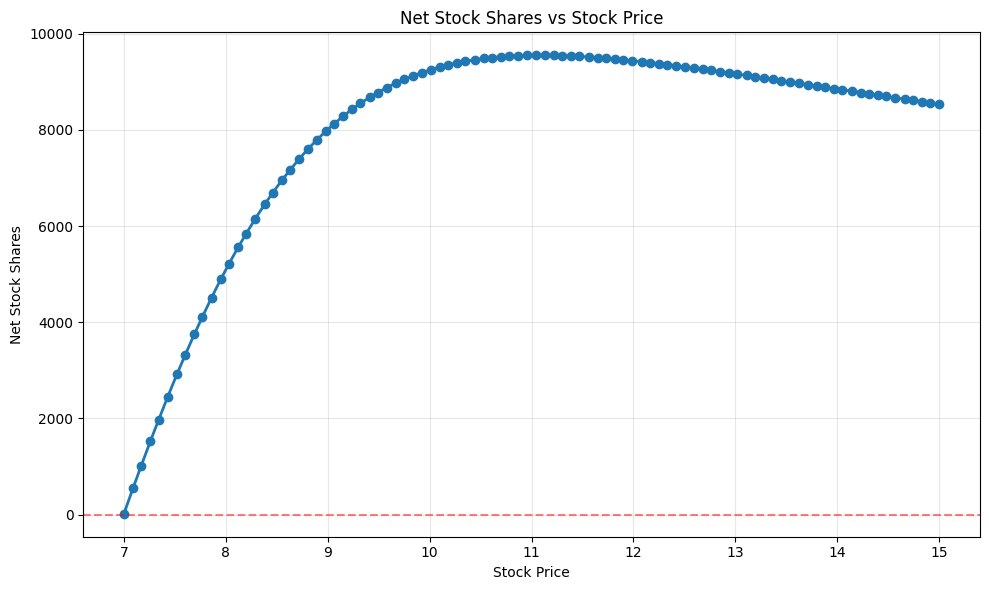

In [19]:

# Plot the net stock shares
plt.figure(figsize=(10, 6))
plt.plot(list(net_stk_shares.keys()), list(net_stk_shares.values()), marker='o', linestyle='-', linewidth=2)
plt.xlabel('Stock Price')
plt.ylabel('Net Stock Shares')
plt.title('Net Stock Shares vs Stock Price')
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## stock pnl calculation

In [25]:
XRX_stock_data = pd.read_parquet('/home/yicheng/credit/opt_stock_data/stock_data_XRX_minute.parquet')

In [26]:
XRX_stock_data

,date,time,ticker,open,high,low,close,avg,volume,amount
0,2020-01-02,09:30:00,XRX,37.090,37.1100,37.00,37.010,37.080700,9830.0,364503.280
1,2020-01-02,09:31:00,XRX,37.100,37.1000,36.96,36.960,37.078300,415.0,15363.908
2,2020-01-02,09:32:00,XRX,36.960,37.0000,36.90,37.000,37.055900,2361.0,87259.494
3,2020-01-02,09:33:00,XRX,36.990,37.0500,36.97,37.040,37.050100,2253.0,83400.730
4,2020-01-02,09:34:00,XRX,37.040,37.1700,37.04,37.140,37.063300,2455.0,91186.583
...,...,...,...,...,...,...,...,...,...,...
568375,2025-10-24,15:55:00,XRX,3.610,3.6100,3.60,3.605,3.607520,91436.0,329926.423
568376,2025-10-24,15:56:00,XRX,3.605,3.6099,3.59,3.595,3.607441,72848.0,262388.093
568377,2025-10-24,15:57:00,XRX,3.590,3.5999,3.59,3.590,3.607270,58251.0,209223.038
568378,2025-10-24,15:58:00,XRX,3.590,3.5950,3.58,3.585,3.607022,60306.0,216206.604


In [63]:
from stock_pnl_calc import *
pnl_merge = analyze_multiple_days_pnl(XRX_stock_data, stock_share_maps)

Calculating daily PnL: 100%|██████████| 1003/1003 [00:37<00:00, 26.67it/s]


<Axes: >

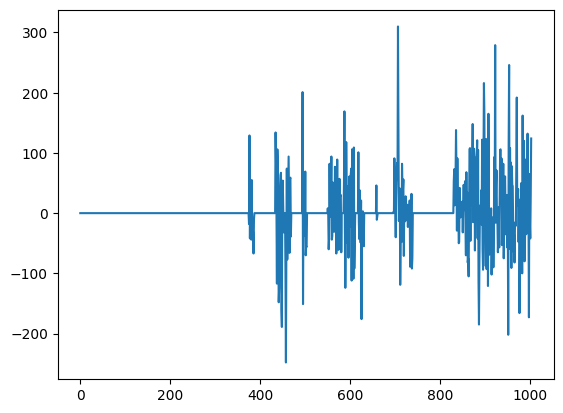

In [69]:
pnl_merge['position_change'].plot()

<Axes: >

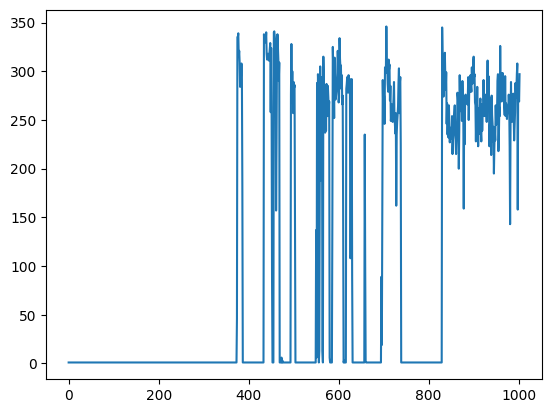

In [71]:
pnl_merge['total_trades'].plot()

<Axes: >

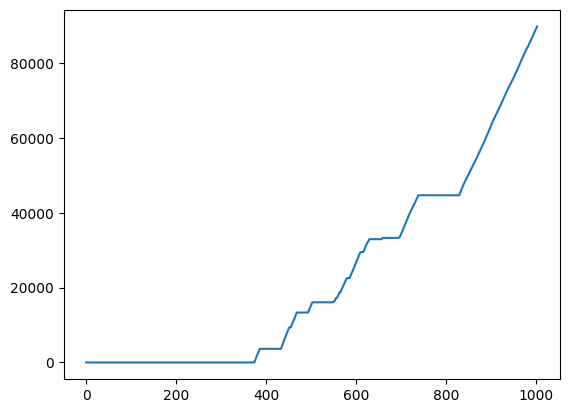

In [81]:
(1 * pnl_merge['rebalance_trades']).cumsum().plot()

In [79]:
pnl_merge.columns

Index(['date', 'opening_price', 'final_price', 'price_change',
       'price_change_pct', 'initial_position', 'final_position',
       'position_change', 'final_position_value', 'cash_flow', 'total_pnl',
       'total_transaction_cost', 'net_pnl', 'total_trades', 'rebalance_trades',
       'total_volume', 'avg_trade_size', 'trade_log', 'pnl_breakdown',
       'cumulative_pnl', 'cumulative_transaction_cost'],
      dtype='object')